In [1]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import uproot
import numpy as np
import awkward as ak
from torch.utils.data import DataLoader
import torch
import datetime
import numpy as np
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
import awkward as ak
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

In [2]:
import uproot
### Energy = 0.15 GeV
root_file1 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF1.root")
root_file2 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF2.root")
tree1 = root_file1["Samples"]
tree2 = root_file2["Samples"]
arrays1 = tree1.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
arrays2 = tree2.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays1["samples"])
X_real = X_real/np.max(X_real, axis = 1).reshape(200000,1)
y_real = ak.to_numpy(arrays1["ysamples"])
X_noise = ak.to_numpy(arrays2["samplesNoise"])
X_noise = X_noise/np.max(X_noise, axis = 1).reshape(200000,1)
y_noise = ak.to_numpy(arrays2["ysamplesNoise"])
X_freal = np.abs(fft(X_real))/5.
X_fnoise = np.abs(fft(X_noise))/5.

print(X_real) 
print("Printing y_real")
print(y_real)

data1 = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
data2 = np.concatenate([X_freal, X_fnoise])
labels = np.concatenate([y_real, y_noise])


# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning

shuffle_indices = np.random.permutation(len(data1))
data1 = data1[shuffle_indices]
data2 = data2[shuffle_indices]
labels = labels[shuffle_indices]

[[-2.18991428 -1.33758012 -0.16379419 ...  0.97133729  0.38098346
  -1.97539871]
 [-0.02620282  0.3494965   0.54694886 ...  0.55314748  0.19741884
  -0.15557223]
 [ 0.70501369  0.95452037  1.         ...  0.82044019  0.71309163
   0.61413221]
 ...
 [-0.03224206 -0.11911494  0.25985249 ...  0.45905995  0.7742844
   1.        ]
 [ 0.42559843  0.71037992  0.30653368 ...  0.96303223  1.
   0.64932407]
 [-0.13804387  0.03573051 -0.07850811 ...  0.81263918  0.81864257
   0.44620173]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [3]:
import awkward as ak

num_events_data = ak.num(data1, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data1, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.7 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
valid_size = train_size + int(0.1 * num_events_data)
train_data1 = data1[:train_size]
train_data2 = data2[:train_size]
train_labels = labels[:train_size]
valid_data1 = data1[train_size:valid_size]
valid_data2 = data2[train_size:valid_size]
valid_labels = labels[train_size:valid_size]
test_data1 = data1[valid_size:]
test_data2 = data2[valid_size:]
test_labels = labels[valid_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : validation data: {len(data1)} : {len(train_data1)} : {len(test_data1)} : {len(valid_data1)}')

number of rows in data is 400000
number of rows in data is 10
Size of training data is 280000
number of elements in data : training data : test data : validation data: 400000 : 280000 : 80000 : 40000


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [5]:
train_data1 = train_data1.reshape((train_data1.shape[0], train_data1.shape[1], 1))
test_data1 = test_data1.reshape((test_data1.shape[0], test_data1.shape[1], 1))
valid_data1 = valid_data1.reshape((valid_data1.shape[0], valid_data1.shape[1], 1))
train_data2 = train_data2.reshape((train_data2.shape[0], train_data2.shape[1], 1))
test_data2 = test_data2.reshape((test_data2.shape[0], test_data2.shape[1], 1))
valid_data2 = valid_data2.reshape((valid_data2.shape[0], valid_data2.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], 1))
test_labels = test_labels.reshape((test_labels.shape[0], 1))
valid_labels = valid_labels.reshape((valid_labels.shape[0], 1))

In [6]:
train_data1 = torch.tensor(train_data1, dtype =torch.float).to(device)
test_data1 = torch.tensor(test_data1, dtype =torch.float).to(device)
valid_data1 = torch.tensor(valid_data1, dtype =torch.float).to(device)
train_data2 = torch.tensor(train_data2, dtype =torch.float).to(device)
test_data2 = torch.tensor(test_data2, dtype =torch.float).to(device)
valid_data2 = torch.tensor(valid_data2, dtype =torch.float).to(device)
train_labels = torch.tensor(train_labels, dtype =torch.float).to(device)
test_labels = torch.tensor(test_labels, dtype =torch.float).to(device)
valid_labels = torch.tensor(valid_labels, dtype =torch.float).to(device)

In [7]:
class ClassifierDataset(Dataset):
    """
    Dataset class used for classifier models.
    
    """
    def __init__(self, 
        data1: torch.tensor,
        data2: torch.tensor,         
        lebel: torch.tensor
        ) -> None:
        
        super().__init__()

        self.data1 = data1
        self.data2 = data2
        self.lebel = lebel

        print("data size = {}".format(data1.size()))
        print("data size = {}".format(data2.size()))
        print("target size = {}".format(lebel.size()))
            

    def __len__(self):
        
        return self.data1.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        data1 = self.data1[index]
        data2 = self.data2[index]
        lebel = self.lebel[index]
        return data1, data2, lebel

In [8]:
training_class = ClassifierDataset(
    data1 = train_data1,
    data2 = train_data2,
    lebel = train_labels)

data size = torch.Size([280000, 10, 1])
data size = torch.Size([280000, 10, 1])
target size = torch.Size([280000, 1])


In [9]:
testing_class = ClassifierDataset(
    data1 = test_data1,
    data2 = test_data2,
    lebel = test_labels)

data size = torch.Size([80000, 10, 1])
data size = torch.Size([80000, 10, 1])
target size = torch.Size([80000, 1])


In [10]:
validing_class = ClassifierDataset(
    data1 = valid_data1,
    data2 = valid_data2,
    lebel = valid_labels)

data size = torch.Size([40000, 10, 1])
data size = torch.Size([40000, 10, 1])
target size = torch.Size([40000, 1])


In [11]:
# Load the training data
training_dataloader = DataLoader(training_class, batch_size= 128)
# Load the testing data
testing_dataloader = DataLoader(testing_class, batch_size= 128)
# Load the validing data
validing_dataloader = DataLoader(validing_class, batch_size= 128)

In [12]:
class Classification_RNN(nn.Module):
    def __init__(self, input_size, hidden_dim1, hidden_dim2, hidden_dim3):
        super().__init__()
        self.rnn_1 = nn.LSTM(input_size, hidden_dim1, 1, bidirectional= True, batch_first= True)
        self.rnn_2 = nn.LSTM(2*hidden_dim1, hidden_dim2, 1, bidirectional= True, batch_first= True)
        self.fc = nn.Linear(2*hidden_dim2, 1)
        self.fc1 = nn.Linear(20, input_size)
        self.activation2 = nn.Sigmoid()
        self.activation1 = nn.ReLU()
        
    def forward(self, src1, src2):
        #print("Intial size",src.size())
        output1, _ = self.rnn_1(src1)
        #print("rnn_1 size",output.size())
        output1, _ = self.rnn_2(output1)
        #print("rnn_2 size",output.size())
        final_output1 = self.fc(output1)
        final_output1 = self.activation2(final_output1)
        final_output1 = final_output1.reshape((final_output1.shape[0], final_output1.shape[1]))
        #print("flatten size", final_output1.size())
        
        #print("Intial size",src.size())
        output2, _ = self.rnn_1(src2)
        #print("rnn_1 size",output.size())
        output2, _ = self.rnn_2(output2)
        #print("rnn_2 size",output.size())
        final_output2 = self.fc(output2)
        final_output2 = self.activation2(final_output2)
        final_output2 = final_output2.reshape((final_output2.shape[0], final_output2.shape[1]))
        #print("flatten size", final_output2.size())        
        
        final_output = torch.cat([final_output1, final_output2], 1)
        #print("flatten size", final_output.size())
        
        final_output = self.fc1(final_output)
        #print("fc2 size", final_output.size())
        final_output = self.activation2(final_output)
        
        return final_output

In [13]:
def create_model():
    input_size = 1
    hidden_dim1 = 16
    hidden_dim2 = 32
    hidden_dim3 = 32
 
    model = Classification_RNN(input_size, hidden_dim1, hidden_dim2, hidden_dim3)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
 
    return model, optimizer, criterion

In [14]:
def train(training_dataloader, validing_dataloader, epochs = 10):
    
    model, optimizer, criterion = create_model()
    
    for epoch in range(1, epochs + 1):
        training_loss = []
        model.train()
        
        for i, (data1, data2, labels) in enumerate(training_dataloader):

            optimizer.zero_grad()

            output = model(data1, data2)

            loss = criterion(output, labels)
                        
            loss.backward()
            
            optimizer.step()
 
            training_loss.append(loss.item())
        
        print(f"At epoch {epoch} mean training loss is {torch.mean(torch.FloatTensor(training_loss))}")
        
        with torch.no_grad():
        
            model.eval()
            
            validation_loss = []
            
            for i, (data1, data2, labels) in enumerate(validing_dataloader):
                #print(data1.shape)
                #print(data2.shape)
                output = model(data1, data2)
                
                loss = criterion(output, labels)
                
                validation_loss.append(loss.item())
            
            print(f"At epoch {epoch} mean validation loss is {torch.mean(torch.FloatTensor(validation_loss))}")
             
    return model

In [15]:
model = train(training_dataloader, validing_dataloader, epochs = 20)

At epoch 1 mean training loss is 0.5810206532478333
At epoch 1 mean validation loss is 0.5102779865264893
At epoch 2 mean training loss is 0.5077044367790222
At epoch 2 mean validation loss is 0.5012480020523071
At epoch 3 mean training loss is 0.5032175779342651
At epoch 3 mean validation loss is 0.49924996495246887
At epoch 4 mean training loss is 0.5013267397880554
At epoch 4 mean validation loss is 0.4981236159801483
At epoch 5 mean training loss is 0.5000591278076172
At epoch 5 mean validation loss is 0.49674418568611145
At epoch 6 mean training loss is 0.49903061985969543
At epoch 6 mean validation loss is 0.4954409897327423
At epoch 7 mean training loss is 0.4981532692909241
At epoch 7 mean validation loss is 0.4942520558834076
At epoch 8 mean training loss is 0.4973006844520569
At epoch 8 mean validation loss is 0.4930616021156311
At epoch 9 mean training loss is 0.4963572919368744
At epoch 9 mean validation loss is 0.49187716841697693
At epoch 10 mean training loss is 0.495279

In [16]:
with torch.no_grad():
    model.eval()
    prediction = ()
    target = ()        
    for i, (data1, data2, labels) in enumerate(testing_dataloader):
        print(f"Step No. ---> {i}")
        output = model(data1,data2)        
        prediction += (output, )
        target += (labels, )

Step No. ---> 0
Step No. ---> 1
Step No. ---> 2
Step No. ---> 3
Step No. ---> 4
Step No. ---> 5
Step No. ---> 6
Step No. ---> 7
Step No. ---> 8
Step No. ---> 9
Step No. ---> 10
Step No. ---> 11
Step No. ---> 12
Step No. ---> 13
Step No. ---> 14
Step No. ---> 15
Step No. ---> 16
Step No. ---> 17
Step No. ---> 18
Step No. ---> 19
Step No. ---> 20
Step No. ---> 21
Step No. ---> 22
Step No. ---> 23
Step No. ---> 24
Step No. ---> 25
Step No. ---> 26
Step No. ---> 27
Step No. ---> 28
Step No. ---> 29
Step No. ---> 30
Step No. ---> 31
Step No. ---> 32
Step No. ---> 33
Step No. ---> 34
Step No. ---> 35
Step No. ---> 36
Step No. ---> 37
Step No. ---> 38
Step No. ---> 39
Step No. ---> 40
Step No. ---> 41
Step No. ---> 42
Step No. ---> 43
Step No. ---> 44
Step No. ---> 45
Step No. ---> 46
Step No. ---> 47
Step No. ---> 48
Step No. ---> 49
Step No. ---> 50
Step No. ---> 51
Step No. ---> 52
Step No. ---> 53
Step No. ---> 54
Step No. ---> 55
Step No. ---> 56
Step No. ---> 57
Step No. ---> 58
Step No

Step No. ---> 494
Step No. ---> 495
Step No. ---> 496
Step No. ---> 497
Step No. ---> 498
Step No. ---> 499
Step No. ---> 500
Step No. ---> 501
Step No. ---> 502
Step No. ---> 503
Step No. ---> 504
Step No. ---> 505
Step No. ---> 506
Step No. ---> 507
Step No. ---> 508
Step No. ---> 509
Step No. ---> 510
Step No. ---> 511
Step No. ---> 512
Step No. ---> 513
Step No. ---> 514
Step No. ---> 515
Step No. ---> 516
Step No. ---> 517
Step No. ---> 518
Step No. ---> 519
Step No. ---> 520
Step No. ---> 521
Step No. ---> 522
Step No. ---> 523
Step No. ---> 524
Step No. ---> 525
Step No. ---> 526
Step No. ---> 527
Step No. ---> 528
Step No. ---> 529
Step No. ---> 530
Step No. ---> 531
Step No. ---> 532
Step No. ---> 533
Step No. ---> 534
Step No. ---> 535
Step No. ---> 536
Step No. ---> 537
Step No. ---> 538
Step No. ---> 539
Step No. ---> 540
Step No. ---> 541
Step No. ---> 542
Step No. ---> 543
Step No. ---> 544
Step No. ---> 545
Step No. ---> 546
Step No. ---> 547
Step No. ---> 548
Step No. -

In [17]:
testing_hat = torch.cat(prediction)
testing_hat.size()

torch.Size([80000, 1])

In [18]:
testing_org = torch.cat(target)
testing_org.size()

torch.Size([80000, 1])

In [19]:
y_test = testing_org.data.cpu().numpy()

In [20]:
predictions = testing_hat.data.cpu().numpy()

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

test labels are: [0. 0. 1. ... 0. 1. 1.]
[[0.11268675]
 [0.11276933]
 [0.04573769]
 ...
 [0.5320127 ]
 [0.64762074]
 [0.03714115]]
[[0.4066484]
 [0.8845629]
 [0.8809953]
 ...
 [0.8892853]
 [0.8938101]
 [0.8563399]]


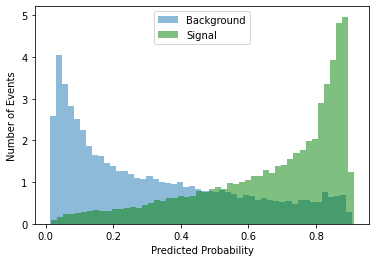

In [64]:
print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5, density=True)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, density=True, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
plt.savefig("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_Freq_Case2.png")
plt.show()

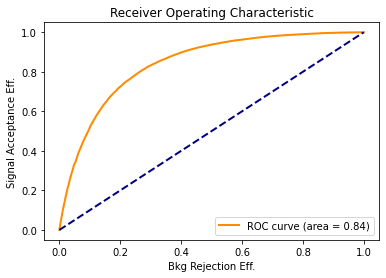

In [63]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Bkg Rejection Eff.')
plt.ylabel('Signal Acceptance Eff.')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
plt.savefig("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_Freq_Case2_ROC.png")
plt.show()

In [24]:
target = torch.from_numpy(y_test.flatten())
pred = torch.from_numpy(predictions.flatten())

In [25]:
from torchmetrics.classification import BinaryConfusionMatrix

In [26]:
metric = BinaryConfusionMatrix(threshold=0.7, normalize = 'true')(pred, target)

In [27]:
metric

tensor([[0.8832, 0.1168],
        [0.4348, 0.5652]])

In [65]:
file = uproot.recreate("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_Freq_SigBkgCase2.root")

In [66]:
file['tree'] = { 
                    "True" : y_test,
                    "Prediction" : predictions
    }

In [67]:
file.close()

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
import uproot
from scipy.stats import norm
from scipy.optimize import curve_fit

In [32]:
num_samples=10
xmin = 0
xmax = 10
bdt_score_min = 0.7
events_to_read = -1

In [33]:
# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * norm.pdf(x, mean, stddev)

In [34]:
def plot_timesamples(ax, time, emsignal_list, legTitle):
    #fig, ax = plt.subplots()
    #for i, emsignal in enumerate(emsignal_list):
    ax.plot(time, emsignal_list, label=f'{legTitle}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
   
    ax.legend()

In [48]:
# Open the ROOT file
#root_file = uproot.open(f"/eos/user/s/shilpi/SWAN_projects/ECAL_noise_EM_discrimination/data/timeSampleTree.root")
root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/timeSampleTree_alcareco.root")

# Access the tree containing the data
tree = root_file["timeSample/EventTreeEle"]

tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
eleE                 | double                   | AsDtype('>f8')
elePt                | double                   | AsDtype('>f8')
eleEta               | double                   | AsDtype('>f8')
elePhi               | double                   | AsDtype('>f8')
hitsAmplitudes       | std::vector<std::vect... | AsObjects(AsVector(True, As...
hitsEnergy           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
hitsThr              | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
nsamples             | int32_t                  | AsDtype('>i4')
e5x5                 | double                   | AsDtype('>f8')
genPt                | double                   | AsDtype('>f8')
genEta               | double                   | AsDtype('>f8')
genPhi               | double                   | AsDtype('>f8')
genE      

In [49]:
# Get the number of entries in the TTree
num_entries = tree.num_entries
print(num_entries)

if(events_to_read==-1):
    events_to_read = num_entries

1973


In [50]:
# Read the needed branches into numpy arrays
arrays = tree.arrays(["elePt", "eleEta", "elePhi", "eleE", "e5x5",
                      "genPt", "genEta", "genPhi", "genE", "gendR",
                     "hitsEnergy", "hitsThr", "hitsAmplitudes"], entry_stop=events_to_read)

In [51]:
elePt = ak.to_numpy(arrays["elePt"])
eleEta = ak.to_numpy(arrays["eleEta"])
elePhi = ak.to_numpy(arrays["elePhi"])
eleE = ak.to_numpy(arrays["eleE"])
e5x5 = ak.to_numpy(arrays["e5x5"])
genPt = ak.to_numpy(arrays["genPt"])
genEta = ak.to_numpy(arrays["genEta"])
genPhi = ak.to_numpy(arrays["genPhi"])
genE = ak.to_numpy(arrays["genE"])
gendR = ak.to_numpy(arrays["gendR"])

In [52]:
# Convert the arrays to a vector of vector format
hitsAmpl = [np.array(arr) for arr in arrays["hitsAmplitudes"]]
hitsEn   = [np.array(arr) for arr in arrays["hitsEnergy"]]
hitsThr  = [np.array(arr) for arr in arrays["hitsThr"]]

In [53]:
energyDiff_pf_array = np.empty(0)
energyDiff_ps_array = np.empty(0)
totE_ps_array = np.empty(0)
e5x5_array = np.empty(0)
genE_array = np.empty(0)

In [54]:
nev=0
totE_ps = 0
for iev in hitsAmpl: ### icrys is ncrys times ntimesamples
    ncrys=0
    totE_ps = 0
    #print(iev)
    for icrys in iev: ## isample is array of ntimesamples
        icrys = icrys/np.max(np.abs(icrys))
        
        input_sample1 = np.reshape(icrys, (1, icrys.shape[0], 1))
        #print(input_sample1.shape)
        input_sample2 = np.abs(fft(input_sample1))/5.
        input_sample2 = np.reshape(icrys, (1, icrys.shape[0], 1))
        input_sample1 = torch.tensor(input_sample1, dtype =torch.float).to(device)
        input_sample2 = torch.tensor(input_sample2, dtype =torch.float).to(device)
        #print(input_sample2.shape)
        bdt_score = model(input_sample1, input_sample2)
        bdt_score = bdt_score.data.cpu().numpy()
        #print(bdt_score)
        #print(hitsEn[nev][ncrys])
        #print(hitsThr[nev][ncrys])
        #print("------------------------------------------------------------")
        if(bdt_score > bdt_score_min):
            totE_ps = totE_ps + hitsEn[nev][ncrys]
        
        #print(f'Energy of this hit is {hitsEn[nev][ncrys]} AND threshold is {hitsThr[nev][ncrys]} .Now the BDT score {bdt_score}')
        ncrys=ncrys+1
    
    print(f'{genE[nev]}:{e5x5[nev]}:{totE_ps}')
    energyDiff_pf = (genE[nev] - e5x5[nev])/genE[nev]
    energyDiff_ps = (genE[nev] - totE_ps)/genE[nev]
    
    energyDiff_pf_array = np.append(energyDiff_pf_array, energyDiff_pf)
    energyDiff_ps_array = np.append(energyDiff_ps_array, energyDiff_ps)
    
    totE_ps_array = np.append(totE_ps_array, totE_ps)
    e5x5_array = np.append(e5x5_array, e5x5)
    genE_array = np.append(genE_array, genE)
    
    nev=nev+1    

print('==========================================================================')

63.903532126956414:37.86916732788086:40.34099880605936
2.148474743066199:3.5563931465148926:4.381317988038063
446.5083817808446:408.3748474121094:412.6176737844944
158.64052503288875:124.72956085205078:133.94837754964828
85.98826236271923:32.730804443359375:66.13149151206017
412.2307169797315:382.9134216308594:444.89980363845825
93.8538044183336:46.112274169921875:58.43163923919201
0.09280492267977951:0.5589107871055603:14.895897056907415
168.51379278570502:130.78016662597656:134.43297508358955
245.73594624469646:210.92349243164062:231.2850753068924
152.46408895851167:121.86319732666016:131.13002640008926
1.1359813811149624:14.368417739868164:18.05310881137848
274.6051309863256:226.58773803710938:265.3131271600723
101.39857264669513:64.4175033569336:80.1352706849575
168.3375238329531:133.15809631347656:164.41096448898315
146.9338269373129:116.74507904052734:122.22548124194145
431.6658692732909:405.37603759765625:430.4186806678772
320.19232800291206:260.63470458984375:315.4798276424408


192.32869975286897:121.63412475585938:133.4265587925911
276.719600567862:219.6701202392578:238.9830083847046
11.674669332798608:12.155838966369629:13.395734824240208
318.27325648109667:262.0770568847656:27.520403265953064
184.18635165136791:155.30615234375:177.0121726989746
183.42127697051225:154.39712524414062:131.3194540143013
0.01496480273549902:252.32945251464844:299.8077278137207
28.640008101777624:114.71198272705078:119.6583227366209
128.78076345373086:108.70958709716797:113.00494286417961
25.977435853080685:21.7796630859375:22.71173158288002
122.72861350954352:132.95835876464844:161.73460936546326
56.98888347859622:43.690006256103516:44.71405407786369
304.12310523066225:276.76910400390625:319.75074529647827
318.83942435215073:229.7681121826172:294.9949080944061
295.8193049928775:297.2535705566406:324.8739535808563
196.50141714883358:171.09852600097656:177.2460367679596
40.38664069625657:26.998607635498047:32.8445344902575
348.77765880744266:270.1941223144531:288.64193844795227
2

252.95718500039308:210.47705078125:227.93147259950638
143.95743829573286:46.879966735839844:86.5473253428936
89.90285676474919:71.96888732910156:74.6847703307867
71.28247684546534:49.838504791259766:53.478305239230394
115.5437222430419:92.186767578125:117.555231153965
162.23260637168158:138.52587890625:148.0398995578289
73.98071887994155:40.26541519165039:43.12977086752653
233.38895560465596:201.08885192871094:213.2451087832451
71.31047975442954:59.51091384887695:60.46375420689583
108.64020958985233:67.81547546386719:86.60268798470497
127.7898848517487:94.00247192382812:104.42282429337502
56.900832012511636:33.45607376098633:33.7284719645977
180.95458117490767:142.64678955078125:151.85431909561157
37.16718572253749:19.63884925842285:30.17652876675129
244.65709522273076:194.5222625732422:222.7648332118988
151.07187769883686:110.69905090332031:128.64843580126762
308.51911215050785:276.5419006347656:309.7255231142044
65.7035389911916:40.401390075683594:41.08143800497055
195.34948855889775

124.27633687005383:85.08521270751953:89.44911906123161
335.790912494859:312.85845947265625:341.8663030862808
27.62019183862696:16.629024505615234:19.850460425019264
0.19781506603307958:7.653720855712891:5.782197318971157
274.84688183231106:217.62301635742188:243.41922372579575
371.4863303051533:305.7536315917969:356.35196125507355
162.92996102156155:133.73724365234375:139.42676582932472
266.7941255712059:207.14341735839844:236.54098784923553
163.1929416812713:120.30540466308594:163.31430089473724
35.545523224697135:27.97530174255371:28.445925623178482
32.297506540309925:20.508848190307617:22.967991448938847
66.39210158080154:24.652477264404297:32.690829038619995
41.49859516282406:28.878114700317383:36.94017378985882
2.857155757783584:54.89252853393555:56.19702619314194
58.58279220673936:24.828933715820312:47.604458659887314
10.19670218560065:148.59197998046875:165.28895124793053
7.36886932569323:160.99908447265625:172.2515434026718
75.6485241994018:27.77107810974121:43.89975634217262
5

41.010386138500834:20.089143753051758:36.690334126353264
0.4383140866063422:9.32749080657959:0.18771721422672272
1.1490031749070504:2.834724187850952:25.852312937378883
108.5041672246611:92.70748901367188:94.0264328122139
374.3180177852037:330.3274841308594:362.9812159538269
158.2749225939506:126.91683959960938:136.00010573863983
0.2133158149718282:3.6185078620910645:4.5687777400016785
212.98698964919927:188.1230010986328:219.01602590084076
88.8545092375298:63.482574462890625:67.02146001905203
0.39692654925689935:164.72767639160156:168.37759211659431
50.50759613682245:36.52863311767578:38.123517863452435
57.700735630638675:32.022518157958984:34.65835130214691
141.7167120334986:108.21944427490234:112.79026158154011
133.09297039574002:109.2706069946289:118.76778829097748
207.51349179937412:187.63912963867188:193.0794060230255
138.30562716374044:103.94659423828125:109.74922007322311
49.6307370977049:46.454647064208984:47.67937786877155
38.093651264937115:36.837425231933594:38.288281716406

344.354790595361:327.3448181152344:359.0993638038635
403.60459632770693:353.58709716796875:386.04520297050476
282.52801218257144:283.38232421875:306.71830439567566
58.945959089608394:42.788909912109375:44.2222485691309
219.88409206791184:212.87530517578125:225.15679350495338
103.00826213824273:81.31976318359375:85.05640891194344
0.039077555775495584:3.321791410446167:3.8570826686918736
49.75784494507116:10.432405471801758:11.3956193998456
125.8439712675667:102.04125213623047:104.59706419706345
159.25340347427002:98.66637420654297:128.64767116308212
319.1954327132394:249.8057861328125:304.2379957437515
22.740733228215458:44.25119400024414:47.62540552020073
261.7120948778367:229.0212860107422:271.35706102848053
118.07039217936654:57.4374885559082:74.55523095279932
73.09457051235435:54.20920181274414:66.56197887659073
3.0177907505384804:6.796904563903809:8.297593370079994
33.32841797406478:56.40507125854492:74.12272289395332
346.8081992907086:273.83349609375:301.77781867980957
37.43575175

393.86133289148506:351.54412841796875:374.68065294623375
38.69741685559169:29.21190643310547:30.783624939620495
81.2445156848192:52.76594543457031:55.04350121319294
73.12099419056484:58.02927780151367:58.96136358380318
195.16873365128282:165.32308959960938:202.8733486533165
81.86634359329527:71.34243774414062:72.95388221740723
129.29746270361105:106.57546997070312:116.62261146306992
102.64587371390112:94.65792846679688:96.60949894785881
0.1755507876209456:4.942631244659424:8.687573421746492
53.89015783885723:41.04964828491211:43.391732167452574
123.18263625274906:110.94144439697266:113.15955476090312
318.4924849816363:290.76708984375:317.1227360367775
223.9849163212945:174.8993377685547:208.80450642108917
240.92210528550763:228.2162322998047:247.9638832807541
196.73969256647354:165.0390625:176.13644808530807
113.56154110179736:92.04438781738281:97.01518231630325
26.18372613468582:22.391456604003906:23.882528517395258
57.175595510310515:30.187808990478516:39.58477225154638
292.705479857

27.94328604147534:16.870630264282227:18.9210042655468
155.19734857902966:135.36497497558594:152.76740396022797
0.01318602242624134:155.14080810546875:164.7099552154541
0.05303162118143005:2.770083427429199:3.5179480388760567
264.1353383920278:208.18801879882812:240.1322832107544
509.5174287587377:440.38201904296875:505.92613446712494
331.3955428465688:282.6921081542969:145.78081166744232
404.9678155381121:340.8446960449219:359.5895357131958
99.93648323671819:43.90790557861328:74.74244630336761
197.55660772921559:174.30409240722656:186.43566143512726
89.73196163206579:66.51089477539062:68.90822158753872
1.93408376705189:8.331483840942383:9.608748510479927
49.99584039638723:34.929893493652344:37.18267595767975
1.9003057404430663:29.193309783935547:43.419253170490265
40.92333427111452:39.33112335205078:39.900304198265076
48.1156178279474:148.98843383789062:172.6775028705597
347.5637766043767:297.0094909667969:356.6643180847168
347.1214738441033:266.14697265625:310.9015349149704
0.07999699

45.46911749108863:46.897361755371094:48.63342262804508
144.75257037176877:132.37045288085938:135.30035946518183
0.3312626456793172:20.423221588134766:26.949499785900116
246.73916626245202:159.42105102539062:170.04178607463837
0.06738289274600354:4.575595855712891:2.1179048344492912
27.015868043356885:17.570568084716797:22.33270563185215
242.80091123869298:194.38433837890625:227.40467083454132
87.40473956799686:84.46340942382812:86.30238404870033
73.56601541293185:61.81597137451172:66.6320680230856
122.59781875673129:92.6947021484375:97.06668865680695
72.68975409702648:57.837825775146484:68.09001964330673
313.4425647177978:258.57427978515625:279.03579741716385
133.56580140611763:225.91920471191406:232.86372504383326
69.48239339653429:58.00424575805664:58.93061538040638
389.35391088055087:74.71549224853516:150.8404483795166
405.42119721059055:333.5374755859375:380.5335717201233
218.54521455039622:194.70010375976562:214.2530128955841
180.08681078508923:146.62033081054688:160.4903694391250

97.67747243478506:86.90525817871094:90.17980441451073
56.01039982137722:53.28449630737305:54.82014273107052
406.936292293266:387.69439697265625:405.44065922498703
232.25114215187338:178.66415405273438:214.22707080841064
169.1494532348735:124.35075378417969:151.29307439923286
282.97827917473376:241.68394470214844:252.50048303604126
252.3454152576777:211.3941650390625:238.8005183339119
295.51762182250815:255.66802978515625:275.8599576950073
259.48684771955254:229.10833740234375:241.60748147964478
77.96979976478379:67.27766418457031:67.87292881309986
0.6925855237818509:3.1356334686279297:25.758394986391068
236.73927965876402:217.2324676513672:228.8712769150734
0.609231057248762:137.4755401611328:144.1824733018875
0.1893579030237906:4.4332051277160645:0.0
45.26271082776302:9.487688064575195:0.668629078194499
0.1895949217810064:8.883069038391113:9.404692977666855
0.9306808545346296:20.14515495300293:22.21905291080475
175.70277450214928:145.7107696533203:154.3832563906908
216.03094265628516:

213.9365427689296:234.9044189453125:249.2180836200714
389.2327755747409:351.91790771484375:374.8399465084076
242.92313793515123:194.3427276611328:227.91001558303833
28.816419061633667:277.02667236328125:302.77056527137756
0.8528027013693662:22.17030906677246:23.99739271402359
290.31741854401287:217.782470703125:270.02027916908264
0.018738352401347757:192.6087646484375:217.2843611240387
60.50953999339416:56.15125274658203:57.50069386512041
242.90657342815624:152.5034942626953:211.24198931455612
115.60202613006821:82.65985107421875:89.2818130850792
271.42185873114613:230.2798309326172:262.2721161842346
231.62980023695619:191.0861053466797:209.75120371580124
0.3596831235093165:5.194047927856445:0.0
57.26167732984516:18.872211456298828:20.756917133927345
111.59583021058508:140.17874145507812:167.90127789974213
144.9161685410586:124.51290130615234:131.12129923701286
289.8731619068071:246.31588745117188:253.4536008834839
1.010671614501261:16.390119552612305:0.0
231.02910557608567:12.49591636

83.0377251402997:56.479454040527344:59.70512719452381
84.23685829068287:66.62071228027344:71.79132034629583
150.41926363999568:121.23236083984375:146.4412989616394
196.32510532950377:154.4288787841797:178.3458662033081
227.3905669723555:162.65835571289062:208.23343932628632
246.04526758949177:209.91128540039062:238.7248396873474
64.2239633975696:34.877315521240234:55.22218295186758
54.61390380581573:52.044036865234375:54.40879090130329
93.10750626324042:64.34965515136719:65.63294886052608
0.7359005067394618:3.8878064155578613:4.982488811016083
0.12278348841969933:5.23609733581543:5.766372308135033
244.75980942112065:384.3203125:452.97355020046234
0.13848548781783382:175.7257537841797:205.5262576341629
166.6870720326031:141.97088623046875:146.24530750513077
230.00941487351:205.09255981445312:217.6543388068676
65.50018918033464:35.80963897705078:64.39186621457338
103.83394061504502:70.2131576538086:75.43988022208214
152.8494682022133:122.64379119873047:138.9571554660797
154.4539296454191

67.68532801325698:53.76727294921875:56.9479296207428
108.82451802422919:42.18195343017578:42.9263941347599
311.2515569833745:288.3204040527344:298.1231303215027
82.61130801048778:56.24651336669922:60.72326475381851
501.132206971311:440.53070068359375:488.5071039199829
0.15522421037101447:4.395026683807373:7.477104961872101
80.20413356177004:75.14359283447266:76.45992939174175
91.00651302727607:53.61399459838867:60.04112195968628
0.001804989330537165:268.7364807128906:331.9179184436798
108.72740510613518:85.31446075439453:94.89466857910156
119.4948721575717:16.583683013916016:21.46965815126896
194.9897217877377:135.35614013671875:173.2860673069954
0.10726398013986338:41.201812744140625:57.19435942173004
125.32643735226351:90.5576171875:97.82058185338974
112.9620471319992:92.82192993164062:98.06582562625408
43.90472326600759:122.61859893798828:135.80079674720764
127.00373854593504:94.010498046875:105.56340900063515
76.93542811562884:54.25687026977539:59.38720367848873
275.67365237190126:

41.85671479045325:37.83194351196289:39.39140962809324
108.68547652606081:93.13397979736328:95.53226867318153
0.2954070594226209:45.1400146484375:52.10092741250992
137.6166940926229:115.85991668701172:132.02334028482437
49.39021110153407:15.479426383972168:21.11258764564991
0.42626728909136924:5.222951889038086:6.1953849866986275
148.69911911485394:125.74347686767578:159.79974591732025
128.23015218544543:124.94810485839844:125.75146319717169
82.96211882712409:51.404266357421875:56.222773775458336
406.4771120523584:340.9022216796875:359.22686886787415
246.11701829398157:216.25001525878906:259.17817211151123
308.06790050058174:277.7710876464844:297.08167666196823
122.38389830464244:59.44954299926758:84.28799678385258
241.64937987011854:185.96652221679688:218.0756994485855
42.75114465387255:21.362409591674805:21.642267122864723


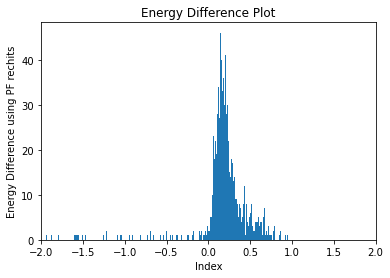

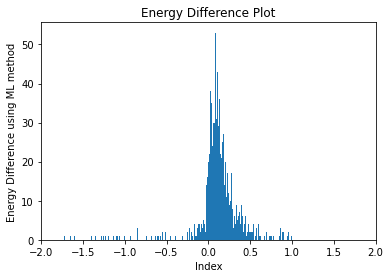

In [55]:
#### plot the diff of energy hists
# Plot the array
plt.hist(energyDiff_pf_array, bins=1000, range=(-3, 3))

# Set the x-axis range
x_min = -2  # Minimum x-value
x_max = 2   # Maximum x-value
plt.xlim(x_min, x_max)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Energy Difference using PF rechits')
plt.title('Energy Difference Plot')

# Display the plot
plt.show()


plt.hist(energyDiff_ps_array, bins=1000, range=(-3, 3))

# Set the x-axis range
x_min = -2  # Minimum x-value
x_max = 2  # Maximum x-value
plt.xlim(x_min, x_max)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Energy Difference using ML method')
plt.title('Energy Difference Plot')

# Display the plot
plt.show()

In [56]:
from scipy.stats import norm
from scipy.optimize import curve_fit

[0.80872622 0.15708723 0.08832405]


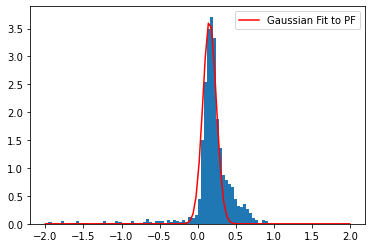

[0.80373049 0.08019802 0.09145418]


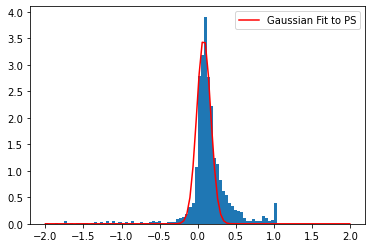

In [57]:
#### Fit both wigh Gaussian

bin_centers1, bin_edges1, _ = plt.hist(energyDiff_pf_array, bins=100, range=(-2, 2), density=True)
bin_width1 = bin_edges1[1] - bin_edges1[0]
#bin_centers = bin_centers * bin_width  # Scale the histogram values to match the area under the curve
bin_centers1 = bin_centers1  # Scale the histogram values to match the area under the curve
p0 = [1, 0.2, 0.08]  # Initial guess for the Gaussian parameters
#params, _ = curve_fit(gaussian, bin_edges[:-1], bin_centers, p0=p0)
params, _ = curve_fit(gaussian, bin_edges1[:-1], bin_centers1, p0=p0)

# Plot the fitted Gaussian curve
x = np.linspace(-2, 2, 100)
y = gaussian(x, *params)
plt.plot(x, y, 'r-', label='Gaussian Fit to PF')

print(params)
# Show the legend
plt.legend()

# Show the plot
plt.show()


bin_centers, bin_edges, _ = plt.hist(energyDiff_ps_array, bins=100, range=(-2, 2), density=True)
bin_width = bin_edges[1] - bin_edges[0]
#bin_centers = bin_centers * bin_width  # Scale the histogram values to match the area under the curve
bin_centers = bin_centers  # Scale the histogram values to match the area under the curve
p0 = [1, 0.2, 0.08]  # Initial guess for the Gaussian parameters
params, _ = curve_fit(gaussian, bin_edges[:-1], bin_centers, p0=p0)

# Plot the fitted Gaussian curve
x = np.linspace(-2, 2, 100)
y = gaussian(x, *params)
plt.plot(x, y, 'r-', label='Gaussian Fit to PS')

print(params)
# Show the legend
plt.legend()

# Show the plot
plt.show()



In [58]:
bin_midpoints = [(bin_edges1[i] + bin_edges1[i + 1]) / 2 for i in range(len(bin_edges1) - 1)]
rms_value1 = np.sqrt(np.sum(np.array(bin_midpoints)**2 * np.array(bin_centers1)) / len(bin_midpoints))
rms_value2 = np.sqrt(np.sum(np.array(bin_midpoints)**2 * np.array(bin_centers)) / len(bin_midpoints))

In [59]:
rms_value1

0.17321710121140488

In [60]:
rms_value2

0.1668527300690945